In [1]:
import os
import numpy as np
import zipfile
from urllib import request
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import keras

%matplotlib inline

Using TensorFlow backend.


In [2]:
from keras import backend as K

def l2_loss(y_pred,y_true):
    return K.sum((K.square(y_true - y_pred)))

In [3]:
import os
print(os.getcwd())
os.chdir('nusta_noise_3slices_15')

D:\beproj\Code


In [4]:
import numpy as np
import glob
Y_train = np.zeros((47,3,256,150), dtype=np.float64)
count = 0
txt_files = glob.glob("nusta_noise_3slices_15/*.nii")
i = 0
for f_name in txt_files:
    b = np.loadtxt(f_name ,delimiter=',')
    if b.size == 115200:
        b = b.reshape(3,256,150)
        Y_train[i] = b
        i = i + 1

In [5]:
i

42

In [6]:
Y_train = Y_train[:42,:,:]
Y_train.shape

(42, 3, 256, 150)

In [7]:
import os
os.chdir('D:/beproj/Code/img_with_noise_3slices_15')

In [8]:
import numpy as np
import glob
X_train = np.zeros((47,3,256,150), dtype=np.float64)
count = 0
txt_files = glob.glob("img_with_noise_3slices_15/*.nii")
i = 0
for f_name in txt_files:
    b = np.loadtxt(f_name ,delimiter=',')
    if b.size == 115200:
        b = b.reshape(3,256,150)
        X_train[i] = b
        i = i + 1     

In [9]:
print(i)
X_train = X_train[:42,:,:]
X_train.shape

42


(42, 3, 256, 150)

In [10]:
import os
os.chdir('D:/beproj/Code/')

In [11]:
from keras.models import load_model
import tensorflow as tf
model = tf.keras.models.load_model('model_with_noise_15.h5',custom_objects={'l2_loss':l2_loss})

W0923 22:28:15.762627 21536 deprecation.py:506] From C:\Users\devendra\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0923 22:28:25.709599 21536 deprecation.py:323] From C:\Users\devendra\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\ops\clip_ops.py:157: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 3, 256, 150, 64)   1792      
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 3, 256, 150, 64)   2359360   
_________________________________________________________________
batch_normalization (BatchNo (None, 3, 256, 150, 64)   256       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 3, 256, 150, 64)   2359360   
_________________________________________________________________
batch_normalization_1 (Batch (None, 3, 256, 150, 64)   256       
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 3, 256, 150, 64)   2359360   
_________________________________________________________________
batch_normalization_2 (Batch (None, 3, 256, 150, 64)   2

In [13]:
#PSNR CALCULATION

import numpy as np
from math import log10, sqrt 
import numpy as np 
  
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    #print("mse:",mse)
    if(mse == 0):  # MSE is zero means no noise is present in the signal.Therefore PSNR have no importance. 
                  
        return 100
    psnr_noisy = 20 * log10(255.0 / sqrt(mse)) 
    #print('PSNR of reconstructed validation images: {psnr}dB'.format(psnr=np.round(psnr_noisy,2)))
    return np.round(psnr_noisy,2)

In [14]:
test_img = X_train - Y_train
test_img.shape

(42, 3, 256, 150)

In [26]:
PSNR(test_img[12],X_train[12])
resi = model.predict(np.array(X_train[12]).reshape(-1,3,256,150,1))
print(resi.shape)
resi = resi.reshape(3,256,150)
PSNR(X_train[12]-resi,X_train[12])

(1, 3, 256, 150, 1)


66.99

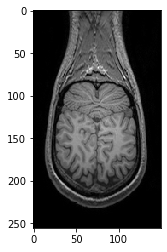

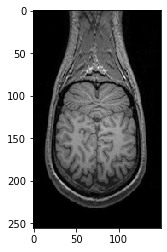

In [27]:
slice_A = X_train[12][1]
fig, ax = plt.subplots()
ax.imshow(slice_A, cmap="gray")
plt.show()

B = X_train[12]-resi
slice_B = B[1]
fig, ax = plt.subplots()
ax.imshow(slice_B, cmap="gray")
plt.show()

In [28]:
noise_inserted = []
noise_removed = []
nins = 0
nrem = 0
for i in range(30,35):
    nins = PSNR(test_img[i],X_train[i])
    resi = model.predict(np.array(X_train[i]).reshape(-1,3,256,150,1))
    resi = resi.reshape(3,256,150)
    nrem = PSNR(X_train[i]-resi,X_train[i])
    noise_inserted.append(nins) 
    noise_removed.append(nrem)

In [29]:
noise_inserted

[63.68, 63.65, 63.71, 63.8, 63.53]

In [30]:
noise_removed

[65.99, 65.96, 67.73, 65.9, 65.84]

In [31]:
slice_A = test_img[35:40]

In [32]:
import random
import numpy as np
def add_rician_noise_to_img(noise_percent,img):
    random_factor = noise_percent * np.random.normal(loc=0., scale=1., size=img.shape)
    noise_image_real = img + random_factor
    noise_image_img = random_factor
    noise_image_real = np.square(noise_image_real) 
    noise_image_img = np.square(noise_image_img) 
    rician_noise_square =  noise_image_img + noise_image_real
    rician_noise_image = np.sqrt(rician_noise_square)
    return rician_noise_image

In [42]:
noise_inserted = []
noise_removed = []
nins = 0
nrem = 0
for i in range(5):
    rr = add_rician_noise_to_img(0.2,slice_A[i])
    nins = PSNR(slice_A[i],rr)
    resi = model.predict(np.array(rr).reshape(-1,3,256,150,1))
    resi = resi.reshape(3,256,150)
    nrem = PSNR(rr-resi,rr)
    noise_inserted.append(nins) 
    noise_removed.append(nrem)

In [43]:
noise_inserted#15 / 20

[59.55, 59.28, 59.7, 59.71, 60.67]

In [44]:
noise_removed#15 / 20

[65.79, 65.36, 66.51, 65.69, 66.38]

In [45]:
noise_inserted = []
noise_removed = []
nins = 0
nrem = 0
for i in range(5):
    rr = add_rician_noise_to_img(0.1,slice_A[i])
    nins = PSNR(slice_A[i],rr)
    resi = model.predict(np.array(rr).reshape(-1,3,256,150,1))
    resi = resi.reshape(3,256,150)
    nrem = PSNR(rr-resi,rr)
    noise_inserted.append(nins) 
    noise_removed.append(nrem)

In [46]:
noise_inserted

[62.92, 62.52, 63.18, 63.22, 64.79]

In [47]:
noise_removed

[65.79, 65.36, 66.51, 65.68, 66.38]